# Final Project

Riju Pant, Andrew ZiYu Wang, Alisa Sumwalt

## Getting Ready

### Imports and Getting the Dataset

In [60]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold, cross_validate
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, log_loss
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

In [61]:
df = pd.read_csv('data.csv')

# from https://www.kaggle.com/datasets/uciml/breast-cancer-wisconsin-data?resource=download
# originally from https://archive.ics.uci.edu/dataset/17/breast+cancer+wisconsin+diagnostic

The dataset we will be using for this project is to do with breast cancer. Breast cancer is a leading cause of death amongst women worldwide, so being able to understand and determine whether one has breast cancer or not is crucial to saving their life. In this notebook, we aim to clasify a tumour as benign or malignant - no harm, or spreads across the body. We got the dataset from Kaggle and it shows 32 columns worth of information for 569 observations. Using this dataset, we want to build classification models to predict the diagnosis, or whether the breast cancer is at a stage that will harm the body or not -we aim to find whether it is malignant or benign. This will be useful for the medical context as predicting the severity of the cancer can help a doctor and patient understand the situation and work towards a solution. Having a working model/models that can give good diagnosis will be key as the key problem with detection of breast cancer is how to classify tumors into the malignant and benign category. Going further, we will understand the dataset and clean it if required, build classification models, and finetune where necessary.

## Exploring the Dataset

In [62]:
print("Information about the Dataset:")
print()

df.info()

row, column = df.shape
print()

print(f"Rows = {row}, Columns = {column}")

Information about the Dataset:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 33 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       569 non-null    int64  
 1   diagnosis                569 non-null    object 
 2   radius_mean              569 non-null    float64
 3   texture_mean             569 non-null    float64
 4   perimeter_mean           569 non-null    float64
 5   area_mean                569 non-null    float64
 6   smoothness_mean          569 non-null    float64
 7   compactness_mean         569 non-null    float64
 8   concavity_mean           569 non-null    float64
 9   concave points_mean      569 non-null    float64
 10  symmetry_mean            569 non-null    float64
 11  fractal_dimension_mean   569 non-null    float64
 12  radius_se                569 non-null    float64
 13  texture_se               569 non-null    float64

Something we find appreciative of this dataset is that everything is a float. When we worked with other datasets previously, we would have some data that should be represented numerically as strings, which would force us to make a new column that has numerical values. Let's learn more about the dataset.

In [63]:
df.head(10)

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN
5,843786,M,12.45,15.70,82.57,477.1,0.12780,0.17000,0.15780,0.08089,...,23.75,103.40,741.6,0.1791,0.5249,0.5355,0.1741,0.3985,0.12440,NaN
6,844359,M,18.25,19.98,119.60,1040.0,0.09463,0.10900,0.11270,0.07400,...,27.66,153.20,1606.0,0.1442,0.2576,0.3784,0.1932,0.3063,0.08368,NaN
7,84458202,M,13.71,20.83,90.20,577.9,0.11890,0.16450,0.09366,0.05985,...,28.14,110.60,897.0,0.1654,0.3682,0.2678,0.1556,0.3196,0.11510,NaN
8,844981,M,13.00,21.82,87.50,519.8,0.12730,0.19320,0.18590,0.09353,...,30.73,106.20,739.3,0.1703,0.5401,0.5390,0.2060,0.4378,0.10720,NaN
9,84501001,M,12.46,24.04,83.97,475.9,0.11860,0.23960,0.22730,0.08543,...,40.68,97.65,711.4,0.1853,1.0580,1.1050,0.2210,0.4366,0.20750,NaN


In [64]:
df.tail(10)

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
559,925291,B,11.51,23.93,74.52,403.5,0.09261,0.10210,0.11120,0.04105,...,37.16,82.28,474.2,0.12980,0.25170,0.3630,0.09653,0.2112,0.08732,NaN
560,925292,B,14.05,27.15,91.38,600.4,0.09929,0.11260,0.04462,0.04304,...,33.17,100.20,706.7,0.12410,0.22640,0.1326,0.10480,0.2250,0.08321,NaN
561,925311,B,11.20,29.37,70.67,386.0,0.07449,0.03558,0.00000,0.00000,...,38.30,75.19,439.6,0.09267,0.05494,0.0000,0.00000,0.1566,0.05905,NaN
562,925622,M,15.22,30.62,103.40,716.9,0.10480,0.20870,0.25500,0.09429,...,42.79,128.70,915.0,0.14170,0.79170,1.1700,0.23560,0.4089,0.14090,NaN
563,926125,M,20.92,25.09,143.00,1347.0,0.10990,0.22360,0.31740,0.14740,...,29.41,179.10,1819.0,0.14070,0.41860,0.6599,0.25420,0.2929,0.09873,NaN
564,926424,M,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,...,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.22160,0.2060,0.07115,NaN
565,926682,M,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,...,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.16280,0.2572,0.06637,NaN
566,926954,M,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,...,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.14180,0.2218,0.07820,NaN
567,927241,M,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,...,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.26500,0.4087,0.12400,NaN
568,92751,B,7.76,24.54,47.92,181.0,0.05263,0.04362,0.00000,0.00000,...,30.37,59.16,268.6,0.08996,0.06444,0.0000,0.00000,0.2871,0.07039,NaN


It seemed that there was an extra column that was probably added accidentally. We decided to drop it.

In [65]:
df = df.drop("Unnamed: 32",axis=1)

### Checking for Null or NA

In [66]:
df.isnull().any()

id                         False
diagnosis                  False
radius_mean                False
texture_mean               False
perimeter_mean             False
area_mean                  False
smoothness_mean            False
compactness_mean           False
concavity_mean             False
concave points_mean        False
symmetry_mean              False
fractal_dimension_mean     False
radius_se                  False
texture_se                 False
perimeter_se               False
area_se                    False
smoothness_se              False
compactness_se             False
concavity_se               False
concave points_se          False
symmetry_se                False
fractal_dimension_se       False
radius_worst               False
texture_worst              False
perimeter_worst            False
area_worst                 False
smoothness_worst           False
compactness_worst          False
concavity_worst            False
concave points_worst       False
symmetry_w

In [67]:
df.isna().any()

id                         False
diagnosis                  False
radius_mean                False
texture_mean               False
perimeter_mean             False
area_mean                  False
smoothness_mean            False
compactness_mean           False
concavity_mean             False
concave points_mean        False
symmetry_mean              False
fractal_dimension_mean     False
radius_se                  False
texture_se                 False
perimeter_se               False
area_se                    False
smoothness_se              False
compactness_se             False
concavity_se               False
concave points_se          False
symmetry_se                False
fractal_dimension_se       False
radius_worst               False
texture_worst              False
perimeter_worst            False
area_worst                 False
smoothness_worst           False
compactness_worst          False
concavity_worst            False
concave points_worst       False
symmetry_w

The fact that the dataset had no missing entires shocked us at first and we were extremely grateful for the luck, but then when we read the description of the dataset on Kaggle, it had mentioned "Missing attribute values: none". Nonetheless, we need to learn more about the dataset. 

In [68]:
df.describe()

,id,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
count,5.690000e+02,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,...,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000
mean,3.037183e+07,14.127292,19.289649,91.969033,654.889104,0.096360,0.104341,0.088799,0.048919,0.181162,...,16.269190,25.677223,107.261213,880.583128,0.132369,0.254265,0.272188,0.114606,0.290076,0.083946
std,1.250206e+08,3.524049,4.301036,24.298981,351.914129,0.014064,0.052813,0.079720,0.038803,0.027414,...,4.833242,6.146258,33.602542,569.356993,0.022832,0.157336,0.208624,0.065732,0.061867,0.018061
min,8.670000e+03,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,0.106000,...,7.930000,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040
25%,8.692180e+05,11.700000,16.170000,75.170000,420.300000,0.086370,0.064920,0.029560,0.020310,0.161900,...,13.010000,21.080000,84.110000,515.300000,0.116600,0.147200,0.114500,0.064930,0.250400,0.071460
50%,9.060240e+05,13.370000,18.840000,86.240000,551.100000,0.095870,0.092630,0.061540,0.033500,0.179200,...,14.970000,25.410000,97.660000,686.500000,0.131300,0.211900,0.226700,0.099930,0.282200,0.080040
75%,8.813129e+06,15.780000,21.800000,104.100000,782.700000,0.105300,0.130400,0.130700,0.074000,0.195700,...,18.790000,29.720000,125.400000,1084.000000,0.146000,0.339100,0.382900,0.161400,0.317900,0.092080
max,9.113205e+08,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,...,36.040000,49.540000,251.200000,4254.000000,0.222600,1.058000,1.252000,0.291000,0.663800,0.207500


There are clearly many features in this dataset, meaning training the model could be a bit challenging, especially if only a select few features are what really helps the model learn. We are curious to see more about the id column and something that was not shown in this table - the diagnosis column.

In [69]:
df["id"].value_counts()

id
842302     1
90250      1
901315     1
9013579    1
9013594    1
          ..
873885     1
873843     1
873701     1
873593     1
92751      1
Name: count, Length: 569, dtype: int64

After looking at the df.head and df.tail of the dataset, and the value counts of the id column, we realized that the id column is just a patient's ID number, and a feature we do not need for training our model. Therefore, we decided to drop the column.

In [70]:
df = df.drop("id", axis=1)

In [71]:
df["diagnosis"].value_counts()

diagnosis
B    357
M    212
Name: count, dtype: int64

When we saw that there are exactly only two classifications, we recalled binary classification, and thought of how we can name our classes as 0 and 1. We decided to just that, where instead of calling a class malignant, we call it 1, and benign as 0.

In [72]:
df["diagnosis"] = df["diagnosis"].map({'M':1,'B':0})

After making sense of some of the columns and what they meant, we tried to understand what the other columns meant. Thanfully, this was mentioned in the description of the dataset on Kaggle.
* id = ID number
* diagnosis = Diagnosis (M = malignant, B = benign)

For the remaining columns, we have "Ten real-valued features are computed for each cell nucleus"
There are:
* radius (mean of distances from center to points on the perimeter)
* texture (standard deviation of gray-scale values)
* perimeter
* area
* smoothness (local variation in radius lengths)
* compactness (perimeter^2 / area - 1.0)
* concavity (severity of concave portions of the contour)
* concave points (number of concave portions of the contour)
* symmetry
* fractal dimension ("coastline approximation" - 1)

The mean, standard error and "worst" or largest (mean of the three largest values) of these features were computed for each image, resulting in 30 features. For instance (when we include id and call it field 1), field 3 is Mean Radius, field 13 is Radius SE, field 23 is Worst Radius.

Upon further research and some guessing, we understood that:
* radius means the size of the cell nucleus. Malignant cells tend to have larger radii, so radius could be an important feature for us
* texture measures the variation in the pixel intensity of a nucleus. This could be an important feature for us because it can help us differentiate between a healthy cell and a malignant one
* perimeter means the total length of the boundary of the cell nucleus. This is an important feature with similar reasons to radius, but would we need both radius and perimeter is a question we should tackle later
* area means the area of the cell nucleus. This is also important for reasons similar to radius and perimeter; need to think whether to keep as a feature or remove later
* smoothness means how smooth or rough the cell nucleus is. Upon researching, breast cancer cells "... often has angular, irregular, asymmetrical edges, as opposed to being smooth..." This would definitely be an important feature for our model (https://www.massgeneralbrigham.org/en/about/newsroom/articles/what-does-a-breast-cancer-lump-feel-like)
* compactness means how much the shape of the cell nuclei deviates from a perfect circle. This would be a very useful feature for us, especially since breast cancer cells, as mentioned above, often have roughness, meaning they would not be a perfect circle. *A perfect circle would have a compactness of 0*
* concavity means how severe the dents in the nucleus cells are. This is also an important feature as breast cancer cells are not exactly smooth
* concave points means how many dents there are in the nucleus cells
* symmetry means how symmetric the cell nucleus us. If the symmetry is low, it would indicate irregularity and could be a possibility for a malignant cell. This could be an important feature
* fractal dimension is an advanced method of measuring how rough the cell nucleus' perimeter is. This is an important feature that could give us reason to not include the perimeter feature as a higher fractal dimension indicates the irregularity of the boundary, which is often a feature of breast cancer cells


Let's look at the dataset as a whole once again:

In [73]:
df.describe()

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
count,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,...,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000
mean,0.372583,14.127292,19.289649,91.969033,654.889104,0.096360,0.104341,0.088799,0.048919,0.181162,...,16.269190,25.677223,107.261213,880.583128,0.132369,0.254265,0.272188,0.114606,0.290076,0.083946
std,0.483918,3.524049,4.301036,24.298981,351.914129,0.014064,0.052813,0.079720,0.038803,0.027414,...,4.833242,6.146258,33.602542,569.356993,0.022832,0.157336,0.208624,0.065732,0.061867,0.018061
min,0.000000,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,0.106000,...,7.930000,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040
25%,0.000000,11.700000,16.170000,75.170000,420.300000,0.086370,0.064920,0.029560,0.020310,0.161900,...,13.010000,21.080000,84.110000,515.300000,0.116600,0.147200,0.114500,0.064930,0.250400,0.071460
50%,0.000000,13.370000,18.840000,86.240000,551.100000,0.095870,0.092630,0.061540,0.033500,0.179200,...,14.970000,25.410000,97.660000,686.500000,0.131300,0.211900,0.226700,0.099930,0.282200,0.080040
75%,1.000000,15.780000,21.800000,104.100000,782.700000,0.105300,0.130400,0.130700,0.074000,0.195700,...,18.790000,29.720000,125.400000,1084.000000,0.146000,0.339100,0.382900,0.161400,0.317900,0.092080
max,1.000000,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,...,36.040000,49.540000,251.200000,4254.000000,0.222600,1.058000,1.252000,0.291000,0.663800,0.207500


In [74]:
df.corr()

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
diagnosis,1.000000,0.730029,0.415185,0.742636,0.708984,0.358560,0.596534,0.696360,0.776614,0.330499,...,0.776454,0.456903,0.782914,0.733825,0.421465,0.590998,0.659610,0.793566,0.416294,0.323872
radius_mean,0.730029,1.000000,0.323782,0.997855,0.987357,0.170581,0.506124,0.676764,0.822529,0.147741,...,0.969539,0.297008,0.965137,0.941082,0.119616,0.413463,0.526911,0.744214,0.163953,0.007066
texture_mean,0.415185,0.323782,1.000000,0.329533,0.321086,-0.023389,0.236702,0.302418,0.293464,0.071401,...,0.352573,0.912045,0.358040,0.343546,0.077503,0.277830,0.301025,0.295316,0.105008,0.119205
perimeter_mean,0.742636,0.997855,0.329533,1.000000,0.986507,0.207278,0.556936,0.716136,0.850977,0.183027,...,0.969476,0.303038,0.970387,0.941550,0.150549,0.455774,0.563879,0.771241,0.189115,0.051019
area_mean,0.708984,0.987357,0.321086,0.986507,1.000000,0.177028,0.498502,0.685983,0.823269,0.151293,...,0.962746,0.287489,0.959120,0.959213,0.123523,0.390410,0.512606,0.722017,0.143570,0.003738
smoothness_mean,0.358560,0.170581,-0.023389,0.207278,0.177028,1.000000,0.659123,0.521984,0.553695,0.557775,...,0.213120,0.036072,0.238853,0.206718,0.805324,0.472468,0.434926,0.503053,0.394309,0.499316
compactness_mean,0.596534,0.506124,0.236702,0.556936,0.498502,0.659123,1.000000,0.883121,0.831135,0.602641,...,0.535315,0.248133,0.590210,0.509604,0.565541,0.865809,0.816275,0.815573,0.510223,0.687382
concavity_mean,0.696360,0.676764,0.302418,0.716136,0.685983,0.521984,0.883121,1.000000,0.921391,0.500667,...,0.688236,0.299879,0.729565,0.675987,0.448822,0.754968,0.884103,0.861323,0.409464,0.514930
concave points_mean,0.776614,0.822529,0.293464,0.850977,0.823269,0.553695,0.831135,0.921391,1.000000,0.462497,...,0.830318,0.292752,0.855923,0.809630,0.452753,0.667454,0.752399,0.910155,0.375744,0.368661
symmetry_mean,0.330499,0.147741,0.071401,0.183027,0.151293,0.557775,0.602641,0.500667,0.462497,1.000000,...,0.185728,0.090651,0.219169,0.177193,0.426675,0.473200,0.433721,0.430297,0.699826,0.438413


It is hard to make sense of this correlation matrix as we have too many columns. Instead, we decided to make a heatmap:

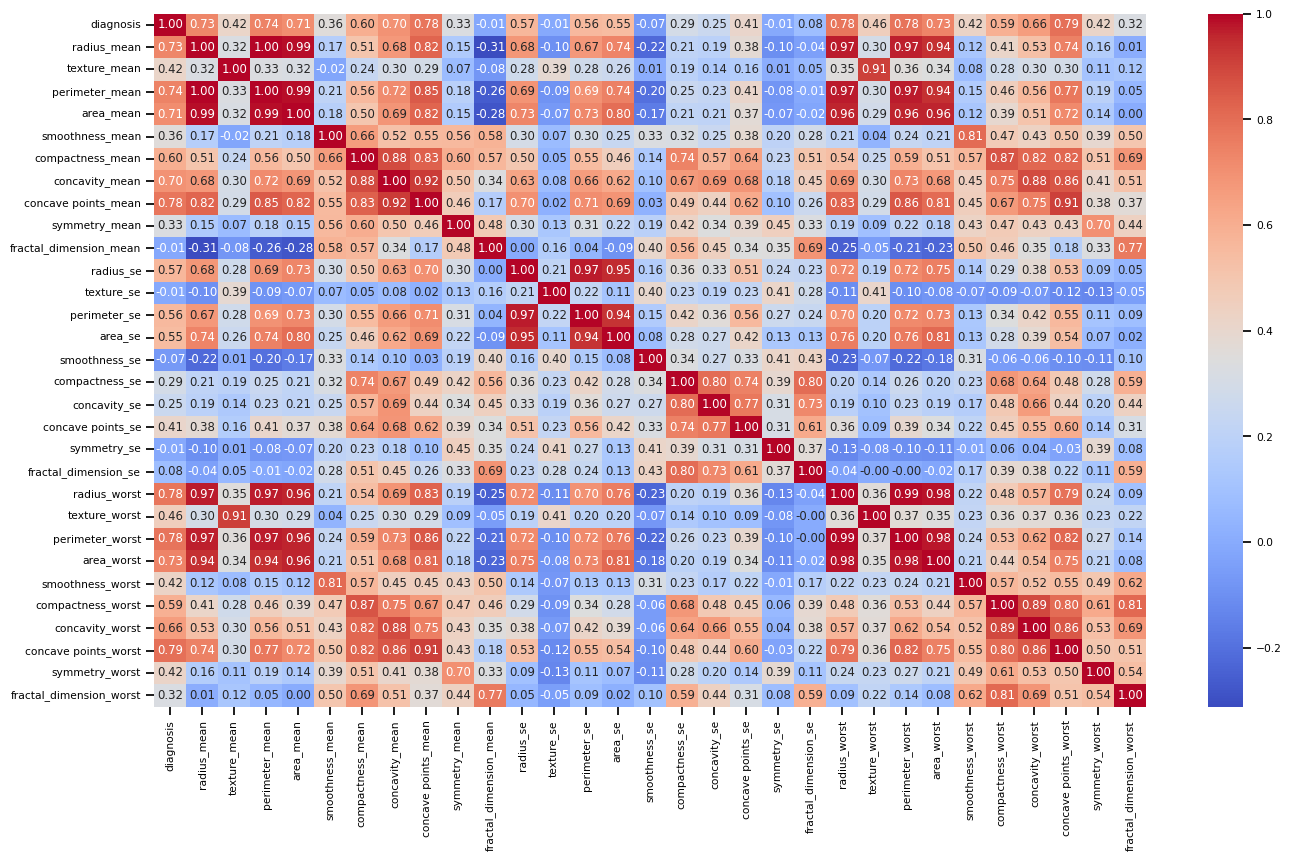

In [75]:
corrMatrix = df.corr()
plt.figure(figsize=(16, 9))
sns.heatmap(
    corrMatrix,
    annot=True,
    cmap='coolwarm',
    fmt=".2f",
    cbar = True
)
plt.show()

This heatmap helps us visualize our correlations, but we realized this is not a good heatmap because it includes our diagnosis values. Since there are 3 sets of 10 real-valued features for each cell nucleus, we decided we can split this into 3 sets.

In [76]:
ftMean = df.columns[1:11]
ftMean = list(ftMean)
ftSE = df.columns[11:21]
ftSE = list(ftSE)
ftWorst = df.columns[21:31]
ftWorst = list(ftWorst)
# print(ftMean)
# print(ftSE)
# print(ftWorst)

Now, we can make a heatmap for the three sets:

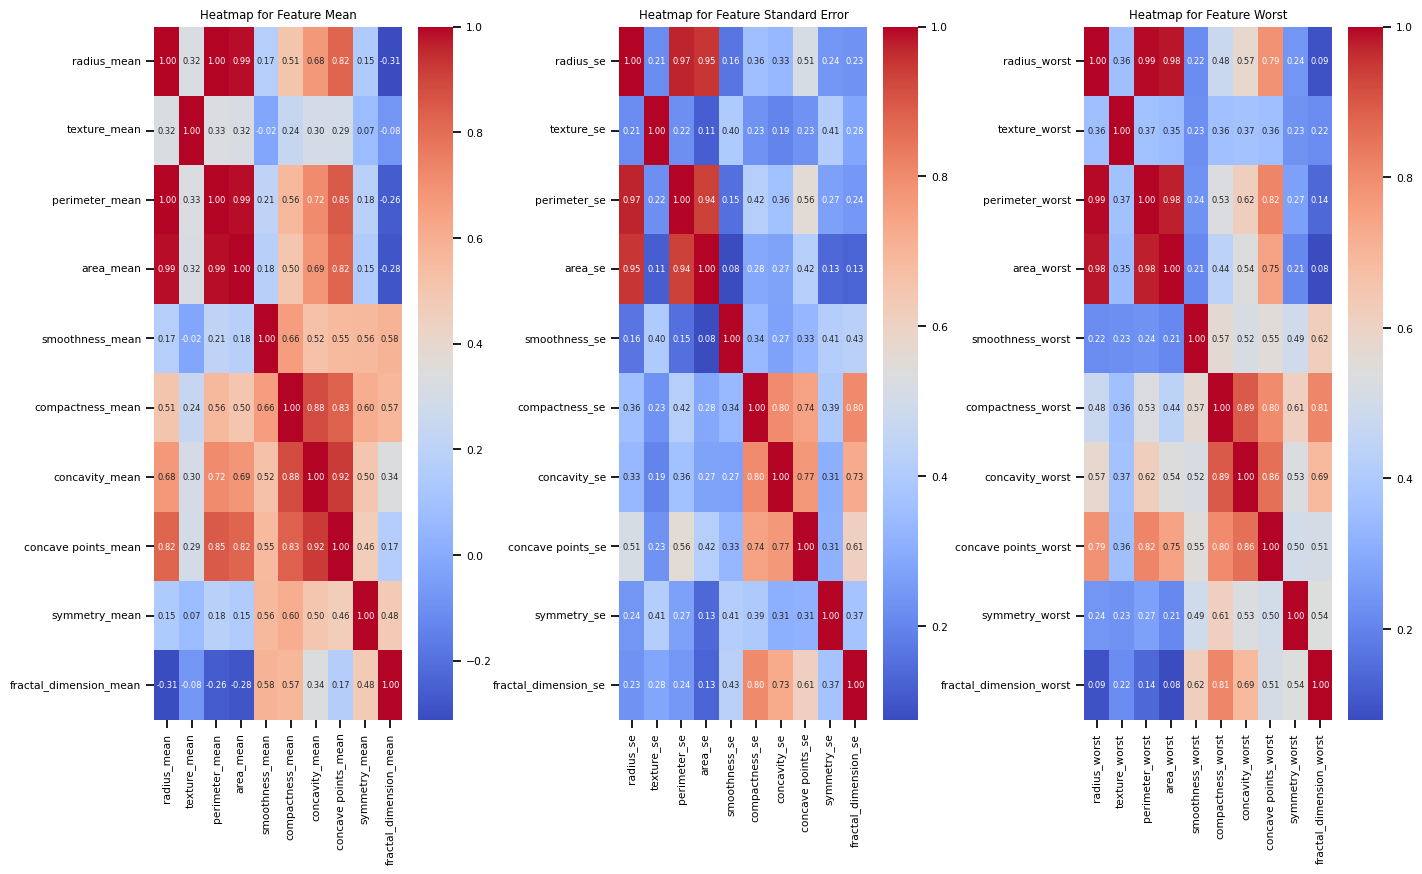

In [77]:
fig, axes = plt.subplots(1, 3, figsize=(16, 9))

sns.set_context("notebook", font_scale=0.7)

corrFtMean = df[ftMean].corr()
sns.heatmap(
    corrFtMean,
    annot=True,
    cmap='coolwarm',
    fmt=".2f",
    cbar = True,
    annot_kws={'size': 6},
    ax=axes[0], 
)
axes[0].set_title('Heatmap for Feature Mean')

corrFtSE = df[ftSE].corr()
sns.heatmap(
    corrFtSE,
    annot=True,
    cmap='coolwarm',
    fmt=".2f",
    cbar = True,
    annot_kws={'size': 6},
    ax=axes[1]
)
axes[1].set_title('Heatmap for Feature Standard Error')

corrFtWorst = df[ftWorst].corr()
sns.heatmap(
    corrFtWorst,
    annot=True,
    cmap='coolwarm',
    fmt=".2f",
    cbar = True,
    annot_kws={'size': 6},
    ax=axes[2]
)
axes[2].set_title('Heatmap for Feature Worst')



# plt.tight_layout(rect=[0, 0, 1, 0])
plt.subplots_adjust(wspace=0.5)
# plt.tight_layout(pad=1)
plt.show()

From the Heatmaps, we can see that
- Radius, Area, and Perimeter are highly correlated, which makes sense because area and perimeter are derived using radius
- Compactness, Concavity, and Concave Points are highly correlated, which makes sense because these three are indicating that the shape of the cell is not a perfect circle

Since we have 10 features which could take time training with, we can reduce the number of features since some of them are highly correlated with each other. Between Radius, Area, and Perimeter, we can choose one of them. Between Compactness, Concavity, and Concave Points, we can choose one of them.

Now we will start working on the models:

## Logistic Regression

In [78]:
def logistic(X, y):
    x_train,x_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=42)
    log = LogisticRegression(max_iter=1000, random_state=42)
    log.fit(x_train,y_train)

    scoringMetrics = ['accuracy', 'f1', 'neg_log_loss']
    cv = KFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_validate(log, X, y, cv=cv, scoring=scoringMetrics)

    predictions = log.predict(x_test)
    print(predictions)

    print(f"Average CV Accuracy: {scores['test_accuracy'].mean():.4f}")
    print(f"Accuracy Standard Deviation: {scores['test_accuracy'].std():.4f}")

    print(f"Average CV F1: {scores['test_f1'].mean():.4f}")
    print(f"F1 Standard Deviation: {scores['test_f1'].std():.4f}")

    print(f"Average CV Log-Loss: {scores['test_neg_log_loss'].mean():.4f}")
    print(f"Log-Loss Standard Deviation: {scores['test_neg_log_loss'].std():.4f}")

    print()

In [ ]:
X = df[ftMean]
y = df['diagnosis']
# x_train,x_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=42)
# log = LogisticRegression(max_iter=1000, random_state=42)
# log.fit(x_train,y_train)

In [80]:
# predictions1 = log.predict(x_test)
# print(predictions1)
# proba = log.predict_proba(x_test)
# print("The log-loss is:", log_loss(y_test, proba))
# accuracy1 = accuracy_score(y_test, predictions1)
# print("accuracy is:", accuracy1)
logistic(X, y)

[0 1 1 0 0 1 1 1 0 0 0 1 0 1 0 1 0 0 0 1 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 1
 0 1 1 0 1 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 1 0 0 0 1 1 1 0 0 1 1 0 0 1 1 0 1
 0 0 0 0 0 0 1 0 1 1 1 1 1 1 0 0 0 0 1 0 0 0 1 1 0 1 1 0 1 1 0 0 0 1 0 0 1
 0 1 1 0 1 0 0 0 1 1 0 0 1 0 1 1 0 0 1 1 1 0 0 0 1 0 0 0 1 0 1 0 0 0 0 1 1
 1 0 1 0 0 0 0 1 1 0 0 0 0 0 0 0 1 0 0 1 0 1 0]
Average CV Accuracy: 0.9138
Accuracy Standard Deviation: 0.0254
Average CV F1: 0.8827
F1 Standard Deviation: 0.0310
Average CV Log-Loss: -0.2039
Log-Loss Standard Deviation: 0.0354



In [81]:
X = df[ftSE]
y = df['diagnosis']
# x_train,x_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=42)
# log = LogisticRegression(max_iter=1000, random_state=42)
# log.fit(x_train,y_train)

# predictions2 = log.predict(x_test)
# print(predictions2)
# proba = log.predict_proba(x_test)
# print("The log-loss is:", log_loss(y_test, proba))
# accuracy2  = accuracy_score(y_test, predictions2)
# print("accuracy is:", accuracy2)
logistic(X, y)

[0 1 1 0 0 1 1 1 0 0 0 1 0 1 0 1 0 0 0 1 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 1
 0 1 0 0 1 0 0 1 0 0 0 0 0 1 1 0 0 0 0 0 1 0 0 0 1 1 0 0 0 1 1 0 0 1 1 0 0
 0 0 0 1 0 0 1 0 0 1 1 1 0 1 0 0 0 0 1 0 0 0 1 1 0 1 1 0 1 1 0 0 0 1 0 0 1
 0 0 1 0 1 0 0 0 0 1 0 0 1 0 1 1 0 0 1 1 0 0 0 0 1 0 0 1 0 0 1 0 0 0 0 1 1
 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 1 0 0 0 0 1 0]
Average CV Accuracy: 0.8892
Accuracy Standard Deviation: 0.0383
Average CV F1: 0.8389
F1 Standard Deviation: 0.0524
Average CV Log-Loss: -0.2944
Log-Loss Standard Deviation: 0.0758



Splitting the data sets into three different data sets since the mean, standard error, and worst of these features were computed for each image. So we can study the correlations between these images and see which set would fit the model the best. 

Accuracy for standard error was 91% which is less than for the mean set (94%). The log loss value for the standard error set was higher than for the mean set, which shows how significant the difference is between the predicted probabilities vs the actual values. 

In [82]:
X = df[ftWorst]
y = df['diagnosis']
# x_train,x_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=42)
# log = LogisticRegression(max_iter=1000, random_state=42)
# log.fit(x_train,y_train)

# predictions3 = log.predict(x_test)
# print(predictions3)
# proba = log.predict_proba(x_test)
# print("The log-loss is:", log_loss(y_test, proba))
# accuracy3 = accuracy_score(y_test, predictions3)
# print("accuracy is:", accuracy3)
logistic(X, y)

[0 1 1 0 0 1 1 1 0 0 0 1 0 1 0 1 0 0 0 1 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 1
 0 1 0 0 1 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 1 0 0 0 1 1 0 0 0 1 1 0 0 1 1 0 1
 0 0 0 0 0 0 1 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0 1 1 0 1 1 0 1 1 0 0 0 1 0 0 1
 0 1 1 0 1 0 0 0 1 0 0 0 1 0 1 1 0 0 1 1 1 0 0 0 1 0 0 0 1 0 1 0 0 1 0 1 1
 1 0 1 0 0 0 0 1 1 0 0 0 0 0 0 0 1 0 0 1 0 1 0]
Average CV Accuracy: 0.9507
Accuracy Standard Deviation: 0.0242
Average CV F1: 0.9344
F1 Standard Deviation: 0.0294
Average CV Log-Loss: -0.1289
Log-Loss Standard Deviation: 0.0514



Intuitive to remove perimeter or area or radius since they are all mathematically related. As you can see the log-loss went down after removing area and perimeter. 

## Support Vector Machine

We will be splitting the dataset into three major catagories: The mean, Standard Error, and worst. This way, we can catagorize the data and make the svms more accurate and efficient. 

In [ ]:
y = df['diagnosis']

# meanX_train,meanX_test,meanY_train,meanY_test = train_test_split(df[ftMean],y,test_size=0.35,random_state=42)
# XSE_train,XSE_test,YSE_train,YSE_test = train_test_split(df[ftSE],y,test_size=0.35,random_state=42)
# worstX_train,worstX_test,worstY_train,worstY_test = train_test_split(df[ftWorst],y,test_size=0.35,random_state=42)

# svm_classifier_mean = SVC(kernel='linear', C=1.0)
# svm_classifier_mean.fit(meanX_train, meanY_train)

# svm_classifier_SE = SVC(kernel='linear', C=1.0)
# svm_classifier_SE.fit(XSE_train, YSE_train)

# svm_classifier_worst = SVC(kernel='linear', C=1.0)
# svm_classifier_worst.fit(worstX_train, worstY_train)

SVC(kernel='linear')

In [135]:
def svm(X, y, C, kernel):
    x_train,x_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=42)

    svm = SVC(kernel='linear', C=C)
    svm.fit(x_train,y_train)

    scoringMetrics = ['accuracy', 'f1']
    cv = KFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_validate(svm, X, y, cv=cv, scoring=scoringMetrics)
    print(f"Average CV Accuracy: {scores['test_accuracy'].mean():.4f}")
    print(f"Accuracy Standard Deviation: {scores['test_accuracy'].std():.4f}")

    print(f"Average CV F1: {scores['test_f1'].mean():.4f}")
    print(f"F1 Standard Deviation: {scores['test_f1'].std():.4f}")

### Lets use SVM and train the data with a margin C of 1.0

Lets use it to predict


In [ ]:
# yPredict = svm_classifier_mean.predict(meanX_test)
# print(accuracy_score(meanY_test, yPredict))
# print(classification_report(meanY_test, yPredict))
svm(df[ftMean], y, C=1, kernel='linear')

Average CV Accuracy: 0.9173
Accuracy Standard Deviation: 0.0279
Average CV F1: 0.8872
F1 Standard Deviation: 0.0336


In [ ]:
# yPredict2 = svm_classifier_SE.predict(XSE_test)
# print(accuracy_score(YSE_test, yPredict2))
# print(classification_report(YSE_test, yPredict))
svm(df[ftSE], y, C=1, kernel='linear')

Average CV Accuracy: 0.8874
Accuracy Standard Deviation: 0.0370
Average CV F1: 0.8359
F1 Standard Deviation: 0.0509


In [ ]:
# yPredict3 = svm_classifier_worst.predict(worstX_test)
# print(accuracy_score(worstY_test, yPredict3))
# print(classification_report(worstY_test, yPredict))
svm(df[ftWorst], y, C=1, kernel='linear')

Average CV Accuracy: 0.9630
Accuracy Standard Deviation: 0.0189
Average CV F1: 0.9509
F1 Standard Deviation: 0.0239


As we can see, the accuracy score is pretty high for all three catagories, especially the worst catagory. This is an indicator for potential high variance due to overfitting. Lets test this with a more flexable margin

In [ ]:
# svm_classifier_mean2 = SVC(kernel='linear', C=5.0)
# svm_classifier_mean2.fit(meanX_train, meanY_train)

# svm_classifier_SE2 = SVC(kernel='linear', C=5)
# svm_classifier_SE2.fit(XSE_train, YSE_train)

# svm_classifier_worst2 = SVC(kernel='linear', C=5)
# svm_classifier_worst2.fit(worstX_train, worstY_train)

# yPredict4 = svm_classifier_mean2.predict(meanX_test)
# print(accuracy_score(meanY_test, yPredict4))
# print(classification_report(meanY_test, yPredict4))

# yPredict5 = svm_classifier_SE2.predict(XSE_test)
# print(accuracy_score(YSE_test, yPredict5))
# print(classification_report(YSE_test, yPredict5))

# yPredict6 = svm_classifier_worst2.predict(worstX_test)
# print(accuracy_score(worstY_test, yPredict6))
# print(classification_report(worstY_test, yPredict6))

svm(df[ftMean], y, C=5, kernel='linear')
print()
svm(df[ftSE], y, C=5, kernel='linear')
print()
svm(df[ftWorst], y, C=5, kernel='linear')




Average CV Accuracy: 0.9208
Accuracy Standard Deviation: 0.0293
Average CV F1: 0.8911
F1 Standard Deviation: 0.0371
Average CV Accuracy: 0.8892
Accuracy Standard Deviation: 0.0421
Average CV F1: 0.8380
F1 Standard Deviation: 0.0590
Average CV Accuracy: 0.9578
Accuracy Standard Deviation: 0.0219
Average CV F1: 0.9437
F1 Standard Deviation: 0.0284


# The result haven't changed much so we will try a polynomial kernel

In [136]:
# svm_classifier_mean2 = SVC(kernel='poly', C=5.0)
# svm_classifier_mean2.fit(meanX_train, meanY_train)

# svm_classifier_SE2 = SVC(kernel='poly', C=5)
# svm_classifier_SE2.fit(XSE_train, YSE_train)

# svm_classifier_worst2 = SVC(kernel='poly', C=5)
# svm_classifier_worst2.fit(worstX_train, worstY_train)

# yPredict4 = svm_classifier_mean2.predict(meanX_test)
# print(accuracy_score(meanY_test, yPredict4))
# print(classification_report(meanY_test, yPredict4))

# yPredict5 = svm_classifier_SE2.predict(XSE_test)
# print(accuracy_score(YSE_test, yPredict5))
# print(classification_report(YSE_test, yPredict5))

# yPredict6 = svm_classifier_worst2.predict(worstX_test)
# print(accuracy_score(worstY_test, yPredict6))
# print(classification_report(worstY_test, yPredict6))


svm(df[ftMean], y, C=5, kernel='poly')
print()
svm(df[ftSE], y, C=5, kernel='poly')
print()
svm(df[ftWorst], y, C=5, kernel='poly')

Average CV Accuracy: 0.9208
Accuracy Standard Deviation: 0.0293
Average CV F1: 0.8911
F1 Standard Deviation: 0.0371

Average CV Accuracy: 0.8892
Accuracy Standard Deviation: 0.0421
Average CV F1: 0.8380
F1 Standard Deviation: 0.0590

Average CV Accuracy: 0.9578
Accuracy Standard Deviation: 0.0219
Average CV F1: 0.9437
F1 Standard Deviation: 0.0284


In [137]:
# svm_classifier_mean2 = SVC(kernel='rbf', C=5.0)
# svm_classifier_mean2.fit(meanX_train, meanY_train)

# svm_classifier_SE2 = SVC(kernel='rbf', C=5)
# svm_classifier_SE2.fit(XSE_train, YSE_train)

# svm_classifier_worst2 = SVC(kernel='rbf', C=5)
# svm_classifier_worst2.fit(worstX_train, worstY_train)

# yPredict4 = svm_classifier_mean2.predict(meanX_test)
# print(accuracy_score(meanY_test, yPredict4))
# print(classification_report(meanY_test, yPredict4))

# yPredict5 = svm_classifier_SE2.predict(XSE_test)
# print(accuracy_score(YSE_test, yPredict5))
# print(classification_report(YSE_test, yPredict5))

# yPredict6 = svm_classifier_worst2.predict(worstX_test)
# print(accuracy_score(worstY_test, yPredict6))
# print(classification_report(worstY_test, yPredict6))

svm(df[ftMean], y, C=5, kernel='rbf')
print()
svm(df[ftSE], y, C=5, kernel='rbf')
print()
svm(df[ftWorst], y, C=5, kernel='rbf')

Average CV Accuracy: 0.9208
Accuracy Standard Deviation: 0.0293
Average CV F1: 0.8911
F1 Standard Deviation: 0.0371

Average CV Accuracy: 0.8892
Accuracy Standard Deviation: 0.0421
Average CV F1: 0.8380
F1 Standard Deviation: 0.0590

Average CV Accuracy: 0.9578
Accuracy Standard Deviation: 0.0219
Average CV F1: 0.9437
F1 Standard Deviation: 0.0284


## Random Forest

After understanding the dataset, we thought good features for the Random Forest would be: radius, texture, smoothness, compactness, symmetry, and fractal dimension. As mentioned previously, some of the features are highly correlated with each other, meaning we can save training time by keeping only one of the highly correlated features.

First, we split the dataset into three parts, each according to their category:

In [91]:
predictorsFtMean = ['radius_mean', 'texture_mean', 'smoothness_mean', 'compactness_mean', 'symmetry_mean', 'fractal_dimension_mean']
predictorsFtSE = ['radius_se', 'texture_se', 'smoothness_se', 'compactness_se', 'symmetry_se', 'fractal_dimension_se']
predictorsFtWorst = ['radius_worst', 'texture_worst', 'smoothness_worst', 'compactness_worst', 'symmetry_worst', 'fractal_dimension_worst']

Now, we set up the Random Forest that we will use to build our models:

In [92]:
modelResults = []

In [93]:
def randomForest(X, y, predictors):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    RF = RandomForestClassifier(
        n_estimators=500,
        random_state=42,
        max_features=len(predictors),
        min_samples_leaf=5
    )

    RF.fit(X_train, y_train)

    # predictionsTraining = RF.predict(X_train)
    # predictions = RF.predict(X_test)
    scoringMetrics = ['accuracy', 'f1']
    cv = KFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_validate(RF, X, y, cv=cv, scoring=scoringMetrics)
    # print(f"Scores for each fold: {scores}")
    print(f"Average CV Accuracy: {scores['test_accuracy'].mean():.4f}")
    print(f"Accuracy Standard Deviation: {scores['test_accuracy'].std():.4f}")

    print(f"Average CV F1: {scores['test_f1'].mean():.4f}")
    print(f"F1 Standard Deviation: {scores['test_f1'].std():.4f}")

    modelResults.append([
        [f"Average CV Accuracy: {scores['test_accuracy'].mean():.4f}"],
        [f"Accuracy Standard Deviation: {scores['test_accuracy'].std():.4f}"],
        [f"Average CV F1: {scores['test_f1'].mean():.4f}"],
        [f"F1 Standard Deviation: {scores['test_f1'].std():.4f}"]
    ])

    return pd.Series(RF.feature_importances_, index=predictors).sort_values(ascending=False)

### Working with the Mean set of features

In [94]:
importantFeaturesFtMean = randomForest(df[predictorsFtMean], df['diagnosis'], predictorsFtMean)

Average CV Accuracy: 0.9209
Accuracy Standard Deviation: 0.0244
Average CV F1: 0.8912
F1 Standard Deviation: 0.0324


In [95]:
print(importantFeaturesFtMean)

radius_mean               0.694043
compactness_mean          0.131352
texture_mean              0.107037
smoothness_mean           0.044376
symmetry_mean             0.013860
fractal_dimension_mean    0.009331
dtype: float64


From the results above, using cross validation, we see that our average accuracy after 5 folds CV is 92.09%, with a standard deviation of 2.4%. We also see that the average F1 score is 89.12%, with a standard deviation of 3.2%. We can see that the model is both highly accurate and reliable. The average scores indicate strong predicitve performance, and the low standard deviations indicate good reproducibility across different subsets of the dataset. A 92.09% average accuracy means that the model accurately identified whether a nucleus cell is malignant or benign 92.09% of the times across the 5 validation folds. The low standard deviation indicates that this was not luck and that the model's performance was consistent and stable. This suggests that the model will work well and similar on new unseen data. An 89.12% F1 score indicates that the model has good precision and recall, and that it minimizes False Positives and False Negatives. Essentially, the high F1 score indicates that it is able to correctly identify true positives well. We can say that the model does well to generalize, and would be able to classify between malignant and benign cells with unseen data. Looking at the important feature, it is clear that the most important feature from ['radius_mean', 'texture_mean', 'smoothness_mean', 'compactness_mean', 'symmetry_mean', 'fractal_dimension_mean'] is radius_mean. An advantage of using Random Forests is because it is able to tell us which features were important for the training and predicting. This is why we wanted to use Random Forests as one of our classification methods. From the 6 features that were used to train this model, radius_mean had an overwhelming importance of 69.4%. This indicates that the radius of the nucles cell tells us a lot about whether it is cancerous or not. Moving further, we want to see how the Random Forest works for the other 2 sets, standard error and worst, however before that, we wanted to see whether the features that we removed would also have high importance. First, we decided to train another Random Forest model without omitting any features from the mean set.

In [96]:
importantFeaturesFtMeanAll = randomForest(df[ftMean], df['diagnosis'], ftMean)

Average CV Accuracy: 0.9456
Accuracy Standard Deviation: 0.0101
Average CV F1: 0.9256
F1 Standard Deviation: 0.0175


In [97]:
print(importantFeaturesFtMeanAll)

concave points_mean       0.789987
texture_mean              0.079509
area_mean                 0.057870
perimeter_mean            0.021545
radius_mean               0.016416
concavity_mean            0.012050
smoothness_mean           0.007860
compactness_mean          0.005678
symmetry_mean             0.005251
fractal_dimension_mean    0.003833
dtype: float64


We were surprised by the results. The average accuracy and the average F1 score both went up, and not by a small amout. They went up by 2% and 3%, and the standard deviation more than halved. The model works much better, only making the points we made earlier for the RF above even stronger for this one. We can say that this model works better because the time it took to train and make the predictions were almost as long as the previous model. One point that surprised us was that the concave points_mean was the feature that showed the most importance, with almost 79%. This was absolutely shocking as we had removed this feature since we thought Compactness, Concavity, and Concave Points were all strongly correlated to each other and we would be fine using only one of them. Now, we want to see how the top 6 features from this importance list perform with their own mode, comparing it with the previous model that also used 6 features, and with this model that uses all features.

In [98]:
ftMeanImportant = list(importantFeaturesFtMeanAll.index[0:6])

In [99]:
importantFeaturesFtMeanMost = randomForest(df[ftMeanImportant], df['diagnosis'], ftMeanImportant)

Average CV Accuracy: 0.9455
Accuracy Standard Deviation: 0.0064
Average CV F1: 0.9258
F1 Standard Deviation: 0.0136


In [100]:
print(importantFeaturesFtMeanMost)

concave points_mean    0.796734
texture_mean           0.085993
area_mean              0.059357
perimeter_mean         0.022220
radius_mean            0.021046
concavity_mean         0.014650
dtype: float64


We have gone in the correct direction, as we have been able to maintain both our accuracy and F1 scores while reducing their standard deviations, after reducing the number of features back down to 6. This means that these 6 features are key to determining whether a cell is malignant or benign. Moving forward for the other two sets, we should start our model with these features.

In [101]:
predictorsFtSE = list(importantFeaturesFtMeanMost.index.str.replace("_mean", "_se"))
predictorsFtWorst = list(importantFeaturesFtMeanMost.index.str.replace("_mean", "_worst"))

### Working with the Standard Error set of features

In [102]:
importantFeaturesFtSE = randomForest(df[predictorsFtSE], df['diagnosis'], predictorsFtSE)

Average CV Accuracy: 0.8998
Accuracy Standard Deviation: 0.0412
Average CV F1: 0.8611
F1 Standard Deviation: 0.0527


In [103]:
print(importantFeaturesFtSE)

area_se              0.727951
radius_se            0.092083
concavity_se         0.076867
texture_se           0.043241
perimeter_se         0.034221
concave points_se    0.025637
dtype: float64


The results were slightly underwhelming, but nonetheless, the model is not bad. In fact, on its own is pretty good, but when comparing to our previous results, the model shows some underperformance. This might be because we are assuming that the best predictors from our mean features are applicable for the others. We should make a model with all the standard error features.

In [104]:
importantFeaturesFtSEAll = randomForest(df[ftSE], df['diagnosis'], ftSE)

Average CV Accuracy: 0.8962
Accuracy Standard Deviation: 0.0469
Average CV F1: 0.8547
F1 Standard Deviation: 0.0637


In [105]:
print(importantFeaturesFtSEAll)

area_se                 0.697083
concavity_se            0.064520
radius_se               0.052248
symmetry_se             0.049006
smoothness_se           0.030672
texture_se              0.029246
perimeter_se            0.020850
fractal_dimension_se    0.020391
concave points_se       0.019027
compactness_se          0.016957
dtype: float64


The results are disappointing as our accuracy and F1 score have dropped after using all the features for our model. This may be because we are using more features that do not really have much importance to making predictions. The addition of features could be an introduction to noise. These features may have little to no importance for the prediction of malginant or benign, and the model may be trying to find relationships between them. Also, adding features can lead to overcomplicating the model, which is why it is underperforming. A phenomenon our steps have shown agreement with is the Curse of Dimensionality. As we increased our features, the data became more spread out, making it harder for the model to find meaningful patterns. Our next step will be to see how the model behaves with the top 6 important features that we have seen here.

In [106]:
ftSEImportant = list(importantFeaturesFtSEAll.index[0:6])

In [107]:
importantFeaturesFtSEMost = randomForest(df[ftSEImportant], df['diagnosis'], ftSEImportant)

Average CV Accuracy: 0.9015
Accuracy Standard Deviation: 0.0439
Average CV F1: 0.8636
F1 Standard Deviation: 0.0563


In [108]:
print(importantFeaturesFtSEMost)

area_se          0.716574
concavity_se     0.085985
radius_se        0.072131
symmetry_se      0.054118
texture_se       0.037649
smoothness_se    0.033543
dtype: float64


Overall, after seeing the results of the three models using the standard error features, it is clear that the mean features are much better at making predictions. We could change the hyperparameters of the Random Forest, however doing so would mean that the model becomes more complex and not worth the training power. Let's continue with the worst set.

### Working with the Worst set of features

In [109]:
importantFeaturesFtWorst = randomForest(df[predictorsFtWorst], df['diagnosis'], predictorsFtWorst)

Average CV Accuracy: 0.9578
Accuracy Standard Deviation: 0.0141
Average CV F1: 0.9436
F1 Standard Deviation: 0.0172


In [110]:
print(importantFeaturesFtWorst)

concave points_worst    0.483566
perimeter_worst         0.229960
area_worst              0.126605
radius_worst            0.105666
texture_worst           0.037945
concavity_worst         0.016258
dtype: float64


Considering how the standard error features model with the most important features from the mean set went, we were well surprised by the results, immediately seeing a 95.8% accuracy and 94.4% F1 score. These are values we welcome with open arms, especially since this was the first model with the worst features. We hypothesize that if we use all the features, we would see the Curse of Dimensionality playing an effect in the results of the next model. Nonetheless, we will see how it goes.

In [111]:
importantFeaturesFtWorstAll = randomForest(df[ftWorst], df['diagnosis'], ftWorst)

Average CV Accuracy: 0.9560
Accuracy Standard Deviation: 0.0125
Average CV F1: 0.9414
F1 Standard Deviation: 0.0148


In [112]:
print(importantFeaturesFtWorstAll)

concave points_worst       0.478298
perimeter_worst            0.225145
area_worst                 0.123660
radius_worst               0.109081
texture_worst              0.032307
concavity_worst            0.012840
symmetry_worst             0.007559
smoothness_worst           0.005942
fractal_dimension_worst    0.002654
compactness_worst          0.002514
dtype: float64


We were surprised to see that the Curse of Dimensionality did not play an effect, and rather, the accuracy increase, though ever so slightly. This was impressive because it shows that the worst features are also able to make good models and good predictions. Something that surprised us was that the top 6 important features for the worst set is coincidentally also the same as the top 6 important features for the mean set. This would mean that these 6 are strong predictors for distinguishing between a malignant cell and a benign cell. Overall, though the introduction of 4 additional features does technically improve the accuracy of the model, and the training time is basically the same as mentioned when building models for the mean dataset, soemthing we realized later on is that our sample size is also small. With a larger sample size, the time it would take to train a model with 6 features vs 10 features would only increase apart. The difference in the two models we made with the worst features are hardly justifible for saying the 10 feature model is worth using. We can safely say that the 6 feature model will perform better and is less expensive to train. To be consistent with how we did the mean and standard error models, we will once again build a model with the top 6 important features we have found.

In [113]:
ftWorstImportant = list(importantFeaturesFtWorstAll.index[0:6])

In [114]:
importantFeaturesFtWorstMost = randomForest(df[ftWorstImportant], df['diagnosis'], ftWorstImportant)

Average CV Accuracy: 0.9560
Accuracy Standard Deviation: 0.0125
Average CV F1: 0.9414
F1 Standard Deviation: 0.0148


In [115]:
print(importantFeaturesFtWorstMost)

concave points_worst    0.483769
perimeter_worst         0.227176
area_worst              0.122680
radius_worst            0.112537
texture_worst           0.037656
concavity_worst         0.016181
dtype: float64


Funnily, when we trained our model with the same 6 features we used for the first one, we yielded slightly different results. This time, we yielded the same results as the 10 feature model. This is interesting as it goes to show that the four extra features that the 10 feature model had where of no no signficance to the model, and removing those 4 had no effects on the prediction of the nucles cells. A possible reason why the results yielded are different, even though we set the random state to 42, from the first random forests is possibly because the order of introducing the predictors may be different. The ordering of this changes the order in which the Random Forests does its operations. Nonetheless, the importance of the features both times were very similar.

### Conclusion from Random Forest

In [116]:
print(modelResults[2])
print(importantFeaturesFtMeanMost)
print("-"*50)
print(modelResults[8])
print(importantFeaturesFtWorstMost)

[['Average CV Accuracy: 0.9455'], ['Accuracy Standard Deviation: 0.0064'], ['Average CV F1: 0.9258'], ['F1 Standard Deviation: 0.0136']]
concave points_mean    0.796734
texture_mean           0.085993
area_mean              0.059357
perimeter_mean         0.022220
radius_mean            0.021046
concavity_mean         0.014650
dtype: float64
--------------------------------------------------
[['Average CV Accuracy: 0.9560'], ['Accuracy Standard Deviation: 0.0125'], ['Average CV F1: 0.9414'], ['F1 Standard Deviation: 0.0148']]
concave points_worst    0.483769
perimeter_worst         0.227176
area_worst              0.122680
radius_worst            0.112537
texture_worst           0.037656
concavity_worst         0.016181
dtype: float64


Looking at the two models that yielded the best results, it seems that for both the mean features and worst features, the same category of features were the most important - concave points, texture, area, perimeter, radius, and concavity. These make sense when we think about it as the number of dents a cell nucleus has is a good indicator of whether it is healthy, and the more dents we have, the more likely it is that it is malignant. The texture, area, perimeter, radius, and concavity also share the same reasons as to why they are important. The shape of the cell nucleus is vital to determining wheter it is cancerous or not, and thanks to Random Forests, we were able to determine that these 6 features hold the most important for classifying new, unseen data. Moving forward, it would be interesting to see if when we use these 6 features, would they also yield better results than using all 10 features.

### Testing 10 vs 6 Features on Logistic Regression and SVM

First, let's try Logistic Regression

In [ ]:
logistic(df[ftMean], df['diagnosis']) # 10 features

[0 1 1 0 0 1 1 1 0 0 0 1 0 1 0 1 0 0 0 1 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 1
 0 1 1 0 1 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 1 0 0 0 1 1 1 0 0 1 1 0 0 1 1 0 1
 0 0 0 0 0 0 1 0 1 1 1 1 1 1 0 0 0 0 1 0 0 0 1 1 0 1 1 0 1 1 0 0 0 1 0 0 1
 0 1 1 0 1 0 0 0 1 1 0 0 1 0 1 1 0 0 1 1 1 0 0 0 1 0 0 0 1 0 1 0 0 0 0 1 1
 1 0 1 0 0 0 0 1 1 0 0 0 0 0 0 0 1 0 0 1 0 1 0]
Average CV Accuracy: 0.9138
Accuracy Standard Deviation: 0.0254
Average CV F1: 0.8827
F1 Standard Deviation: 0.0310
Average CV Log-Loss: -0.2039
Log-Loss Standard Deviation: 0.0354



In [ ]:
logistic(df[importantFeaturesFtMeanMost.index], df['diagnosis']) # 6 features

[0 1 1 0 0 1 1 1 0 0 0 1 0 1 0 1 0 0 0 1 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 1
 0 1 1 0 1 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 1 0 0 0 1 1 1 0 0 1 1 0 0 1 1 0 1
 0 0 0 0 0 0 1 0 1 1 1 1 1 1 0 0 0 0 1 0 0 0 1 1 0 1 1 0 1 1 0 0 0 1 0 0 1
 0 1 1 0 1 0 0 0 1 1 0 0 1 0 1 1 0 0 1 1 1 0 0 0 1 0 0 0 1 0 1 0 0 0 0 1 1
 1 0 1 0 0 0 0 1 1 0 0 0 0 0 0 0 1 0 0 1 0 1 0]
Average CV Accuracy: 0.9121
Accuracy Standard Deviation: 0.0232
Average CV F1: 0.8798
F1 Standard Deviation: 0.0278
Average CV Log-Loss: -0.2057
Log-Loss Standard Deviation: 0.0357



In [ ]:
logistic(df[ftSE], df['diagnosis']) # 10 features

[0 1 1 0 0 1 1 1 0 0 0 1 0 1 0 1 0 0 0 1 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 1
 0 1 0 0 1 0 0 1 0 0 0 0 0 1 1 0 0 0 0 0 1 0 0 0 1 1 0 0 0 1 1 0 0 1 1 0 0
 0 0 0 1 0 0 1 0 0 1 1 1 0 1 0 0 0 0 1 0 0 0 1 1 0 1 1 0 1 1 0 0 0 1 0 0 1
 0 0 1 0 1 0 0 0 0 1 0 0 1 0 1 1 0 0 1 1 0 0 0 0 1 0 0 1 0 0 1 0 0 0 0 1 1
 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 1 0 0 0 0 1 0]
Average CV Accuracy: 0.8892
Accuracy Standard Deviation: 0.0383
Average CV F1: 0.8389
F1 Standard Deviation: 0.0524
Average CV Log-Loss: -0.2944
Log-Loss Standard Deviation: 0.0758



In [ ]:
logistic(df[importantFeaturesFtSEMost.index], df['diagnosis']) # 6 features

[0 1 1 0 0 1 1 1 0 0 0 1 0 1 0 1 0 0 0 1 0 0 1 0 0 0 0 0 0 1 0 0 1 0 0 0 1
 0 1 0 0 1 0 0 1 0 0 0 0 0 1 1 0 0 0 0 0 1 0 0 0 1 1 0 0 0 1 1 0 0 1 1 0 0
 0 0 0 1 0 0 1 0 0 1 1 1 0 1 0 0 0 0 1 0 0 0 1 1 0 1 1 0 1 1 0 0 0 1 0 0 1
 0 0 1 0 1 0 0 0 0 1 0 0 1 0 1 1 0 0 1 1 0 0 0 0 1 0 0 1 0 0 1 0 0 0 0 1 1
 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 1 0 0 0 0 1 0]
Average CV Accuracy: 0.8874
Accuracy Standard Deviation: 0.0374
Average CV F1: 0.8359
F1 Standard Deviation: 0.0510
Average CV Log-Loss: -0.2959
Log-Loss Standard Deviation: 0.0751



In [ ]:
logistic(df[ftWorst], df['diagnosis']) # 10 features

[0 1 1 0 0 1 1 1 0 0 0 1 0 1 0 1 0 0 0 1 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 1
 0 1 0 0 1 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 1 0 0 0 1 1 0 0 0 1 1 0 0 1 1 0 1
 0 0 0 0 0 0 1 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0 1 1 0 1 1 0 1 1 0 0 0 1 0 0 1
 0 1 1 0 1 0 0 0 1 0 0 0 1 0 1 1 0 0 1 1 1 0 0 0 1 0 0 0 1 0 1 0 0 1 0 1 1
 1 0 1 0 0 0 0 1 1 0 0 0 0 0 0 0 1 0 0 1 0 1 0]
Average CV Accuracy: 0.9507
Accuracy Standard Deviation: 0.0242
Average CV F1: 0.9344
F1 Standard Deviation: 0.0294
Average CV Log-Loss: -0.1289
Log-Loss Standard Deviation: 0.0514



In [ ]:
logistic(df[importantFeaturesFtWorstMost.index], df['diagnosis']) # 6 features

[0 1 1 0 0 1 1 1 0 0 0 1 0 1 0 1 0 0 0 1 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 1
 0 1 0 0 1 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 1 0 0 0 1 1 0 0 0 1 1 0 0 1 1 0 1
 0 0 0 0 0 0 1 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0 1 1 0 1 1 0 1 1 0 0 0 1 0 0 1
 0 1 1 0 1 0 0 0 1 0 0 0 1 0 1 1 0 0 1 1 1 0 0 0 1 0 0 0 1 0 1 0 0 1 0 1 1
 1 0 1 0 0 0 0 1 1 0 0 0 0 0 0 0 1 0 0 1 0 1 0]
Average CV Accuracy: 0.9490
Accuracy Standard Deviation: 0.0240
Average CV F1: 0.9322
F1 Standard Deviation: 0.0293
Average CV Log-Loss: -0.1360
Log-Loss Standard Deviation: 0.0536



From the above results, it seems that there are no significant differences between training the model on 10 features or 6 features. The difference is extremely insignificant to the point where we may want to prioritize using the model that uses less features as it yields the same results as the model with 10. If we had larger datasets to train with, then the model with 6 features would be better, however with our sample size, it may be best to use the model with all 10 features as it still technically yields the better result.

Now, let's try SVM

In [ ]:
svm(df[ftMean], df['diagnosis']) # 10 features

Average CV Accuracy: 0.9173
Accuracy Standard Deviation: 0.0279
Average CV F1: 0.8872
F1 Standard Deviation: 0.0336


In [ ]:
svm(df[importantFeaturesFtMeanMost.index], df['diagnosis']) # 6 features

Average CV Accuracy: 0.9156
Accuracy Standard Deviation: 0.0285
Average CV F1: 0.8849
F1 Standard Deviation: 0.0350


In [ ]:
svm(df[ftSE], df['diagnosis']) # 10 features

Average CV Accuracy: 0.8874
Accuracy Standard Deviation: 0.0370
Average CV F1: 0.8359
F1 Standard Deviation: 0.0509


In [ ]:
svm(df[importantFeaturesFtSEMost.index], df['diagnosis']) # 6 features

Average CV Accuracy: 0.8857
Accuracy Standard Deviation: 0.0369
Average CV F1: 0.8313
F1 Standard Deviation: 0.0504


In [ ]:
svm(df[ftWorst], df['diagnosis']) # 10 features

Average CV Accuracy: 0.9630
Accuracy Standard Deviation: 0.0189
Average CV F1: 0.9509
F1 Standard Deviation: 0.0239


In [ ]:
svm(df[importantFeaturesFtWorstMost.index], df['diagnosis']) # 6 features

Average CV Accuracy: 0.9560
Accuracy Standard Deviation: 0.0202
Average CV F1: 0.9411
F1 Standard Deviation: 0.0257


The same as logistic regression can be concluded for SVMs.

## Conclusion

We used three models to 